<a href="https://colab.research.google.com/github/saleh1312/nlp_projects/blob/main/TEMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from os.path import join

In [2]:
f=4
sh=224
sw=224
shape=(int(sh/f),int(sw/f))
vgg =tf.keras.applications.VGG16(include_top=False,input_shape=(shape[0],shape[1],3) )
vgg.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 56, 56, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 56, 56, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 56, 56, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 28, 28, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 28, 28, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 28, 28, 128)       147584    
                                                              

In [ ]:
path='/content/drive/MyDrive/kaggle_dataset/cat-and-dog/training_set/training_set/'
cat_enc={'cats':0,'dogs':1}
images=[]
parts=[]
parts_encode=[]
labels=[]

for category in os.listdir(path):
  num_image=0
  for img_path in os.listdir(path+category+'/'):
    if num_image==300:
      break
    if img_path[-4:] !='.jpg':
      continue
    #read image ,resize , bgr2rgb
    img=cv2.imread(path+category+'/'+img_path)
    img=cv2.resize(img,(sw,sh))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    images.append(img)
    #make parts
    parts_img=[]
    parts_vgg=[]
    for y in range(0,img.shape[0],shape[0]):
      for x in range(0,img.shape[1],shape[1]):
        part=img[y:y+shape[0],x:x+shape[1]]
        parts_img.append(part)
        pred= vgg.predict(part.reshape((1,part.shape[0],part.shape[1],3)))[0].reshape( (512) )
        parts_vgg.append(pred)
    parts.append(parts_img)
    parts_encode.append(parts_vgg)
    #add labels
    labels.append(cat_enc[category])
    num_image+=1

In [ ]:
images_=np.array(images)
parts_=np.array(parts)
parts_encode_=np.array(parts_encode)
labels_=np.array(labels)

In [ ]:
parts_encode_.shape

(600, 16, 512)

In [ ]:
np.save('/content/drive/MyDrive/kaggle_dataset/cat-and-dog/cat_dogs_300/images_.npy',images_)
np.save('/content/drive/MyDrive/kaggle_dataset/cat-and-dog/cat_dogs_300/parts_.npy',parts_)
np.save('/content/drive/MyDrive/kaggle_dataset/cat-and-dog/cat_dogs_300/parts_encode_.npy',parts_encode_)
np.save('/content/drive/MyDrive/kaggle_dataset/cat-and-dog/cat_dogs_300/labels_.npy',labels_)

In [3]:
images_=np.load('/content/drive/MyDrive/kaggle_dataset/cat-and-dog/cat_dogs_300/images_.npy')
parts_=np.load('/content/drive/MyDrive/kaggle_dataset/cat-and-dog/cat_dogs_300/parts_.npy')
parts_encode_=np.load('/content/drive/MyDrive/kaggle_dataset/cat-and-dog/cat_dogs_300/parts_encode_.npy')
labels_=np.load('/content/drive/MyDrive/kaggle_dataset/cat-and-dog/cat_dogs_300/labels_.npy')

In [4]:
parts_encode_=parts_encode_.astype(np.float32)
labels_=labels_.astype(np.float32)

In [5]:
from sklearn.utils import shuffle
i_,p_,pe_,l_=shuffle(images_,parts_,parts_encode_,labels_)

In [6]:
input=tf.keras.Input((16,512))
h0,h1,c=tf.keras.layers.LSTM(100,return_sequences=True,return_state=True)(input)
d=tf.keras.layers.Dense(100,activation='tanh')(h1)
resh=tf.keras.layers.Reshape((1,100))(d)
attn_out ,attn_states= tf.keras.layers.Attention()(
    [resh, h0],return_attention_scores=True)
soft=tf.keras.layers.Softmax(axis=-1)(attn_states)
resh=tf.keras.layers.Reshape((100,))(attn_out)
decoder_concat_input = tf.keras.layers.Concatenate(axis=-1, name='concat_layer')([d, resh])
dd=tf.keras.layers.Dense(16,activation='relu')(decoder_concat_input)
clas=tf.keras.layers.Dense(1,activation='sigmoid')(dd)

model=tf.keras.Model(input,clas)
model2=tf.keras.Model(input,[clas,soft])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 16, 512)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 16, 100),    245200      ['input_2[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 dense (Dense)                  (None, 100)          10100       ['lstm[0][1]']                   
                                                                                            

In [8]:
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(0.01))
model2.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(0.01))

In [9]:
model.fit(pe_,l_,batch_size=32,epochs=100)

Epoch 1/100
19/19 [==============================] - 3s 38ms/step - loss: 0.6808
Epoch 2/100
19/19 [==============================] - 1s 37ms/step - loss: 0.4746
Epoch 3/100
19/19 [==============================] - 1s 37ms/step - loss: 0.3759
Epoch 4/100
19/19 [==============================] - 1s 36ms/step - loss: 0.3042
Epoch 5/100
19/19 [==============================] - 1s 36ms/step - loss: 0.1887
Epoch 6/100
19/19 [==============================] - 1s 35ms/step - loss: 0.1279
Epoch 7/100
19/19 [==============================] - 1s 36ms/step - loss: 0.0882
Epoch 8/100
19/19 [==============================] - 1s 36ms/step - loss: 0.1032
Epoch 9/100
19/19 [==============================] - 1s 35ms/step - loss: 0.0926
Epoch 10/100
19/19 [==============================] - 1s 36ms/step - loss: 0.1562
Epoch 11/100
19/19 [==============================] - 1s 37ms/step - loss: 0.1015
Epoch 12/100
19/19 [==============================] - 1s 35ms/step - loss: 0.0733
Epoch 13/100
19/19 [=====

KeyboardInterrupt: ignored

In [11]:
pe_.shape

(600, 16, 512)

[[0.00011628]]


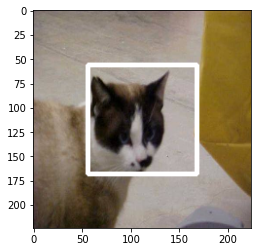

In [83]:
i=np.random.randint(0,600)
img=i_[i].copy()
pred,attn=model2.predict( np.reshape(pe_[i] , (1,pe_.shape[1],pe_.shape[2]) ) )
print(pred)
ff=np.argmax(attn.reshape((16)))

r=0
for y in range(0,img.shape[0],shape[0]):
  for x in range(0,img.shape[1],shape[1]):
    if x/shape[0] + r ==ff:

      cv2.rectangle(img, (x,y),(x+x+shape[0],y+y+shape[1]), (255,255,255), 3)

  r+=4
  

plt.imshow(img)

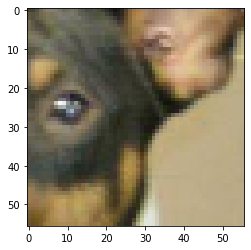

In [74]:
plt.imshow(p_[i,ff])